In [1]:
import sys
import os
import xml.etree.ElementTree
import csv
import re
import sqlite3
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

% matplotlib inline

# Openstreetmap Project

The goal of this project is to parse data from a openstreetmap OSM file (XML format), populate a database and perform some analysis.

## List of modules used

In [2]:
print("Python: Version {}".format(sys.version))
print("xml.etree.ElementTree: xml is a python embedded module. Please refer to the python's version.")
print("csv: Version {}".format(csv.__version__))
print("re: Version {}".format(re.__version__))
#print("sqlite3: Version {}".format(sqlite3.__version__))
print("pandas: Version {}".format(pd.__version__))
print('matplotlib: Version {}'.format(matplotlib.__version__))
print('numpy: Version {}'.format(np.__version__))

Python: Version 3.6.0 |Anaconda 4.3.1 (32-bit)| (default, Dec 23 2016, 12:06:52) [MSC v.1900 32 bit (Intel)]
xml.etree.ElementTree: xml is a python embedded module. Please refer to the python's version.
csv: Version 1.0
re: Version 2.2.1
pandas: Version 0.19.2
matplotlib: Version 2.0.0
numpy: Version 1.11.3


## Set the data file

In [130]:
#dataFileName = 'example.osm'
#dataFileName = 'daensen.osm'
dataFileName = 'pippensen.osm'

#dataFileName = 'Hamburg_sued.osm'
#dataFileName = 'Buxtehude.osm'
#dataFileName = 'Paris.osm'

In [131]:
statinfo = os.stat(dataFileName)
print('Size of the source file {}: {:.3f}Mb'.format(dataFileName, statinfo.st_size / (1024 * 1024))) 

Size of the source file pippensen.osm: 6.207Mb


Database filename

In [132]:
dbFileName = 'Openstreetmap.db'

# Read data from OSM file and create some csv files

In [133]:
# List of all csv files
csvFiles = {'node':'nodes.csv',
         'way':'ways.csv',
         'node_tags': 'nodes_tags.csv',
         'way_tags': 'ways_tags.csv',
         'way_node':'ways_nodes.csv'}

# List of all fields for the csv files
fields = {'node': ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp'],
           'way': ['id', 'user', 'uid', 'version', 'changeset', 'timestamp'],
           'node_tags': ['id', 'key', 'value', 'type'],
           'way_tags': ['id', 'key', 'value', 'type'],
           'way_node': ['id', 'node_id', 'position']} 

def initCSVfiles():
    '''
    Create empty csv files and add the header line
    
    parameters:
    ------------
    None
    
    returns:
    --------
    a dictionary containing the file descriptor and the csv writer object
    '''
    fileDescriptor = {}
    for f in csvFiles:
        #print('init {}'.format(files[f]))
        fileId = open(csvFiles[f], 'w', encoding='utf-8')
        csvWriter = csv.writer(fileId, delimiter=';',
                            quotechar='\'', quoting=csv.QUOTE_MINIMAL)
        csvWriter.writerow(fields[f])
        fileDescriptor[f] = {}
        fileDescriptor[f]['fileId'] = fileId
        fileDescriptor[f]['csvWriter'] = csvWriter
        
    return fileDescriptor

def closeCSVfiles(fileDesc):
    '''
    Close all csv files opened
    
    parameters:
    -----------
    the file descriptor dictionary returned by the initCSVfiles function.
    
    returns:
    --------
    None
    '''
    for f in fileDesc:
        fileDesc[f]['fileId'].close()

def writeElem(elemType, elem, fileDesc):
    '''
    write an element in the corresponding csv file
    
    parameters:
    -----------
    - elemType: a string of the type of element to be written.
    - elem: dict of data to be written in the csv file
    - fileDesc: dictionary of the file decriptor (given by the initCSVfiles function)
    '''
    record = []
    for i in fields[elemType]:
        record.append(elem[i])
    
    fileDesc[elemType]['csvWriter'].writerow(record)

def correctBadCaracter(string):
    '''
    remove problematic charracteres from a stings.
    
    All special character in the form '&#xxx;' will be removed and semi-colon will be replaced by a space char.
    
    parameters:
    -----------
    - string: the string to be cerrected
    
    returns:
    --------
    the input string without problematic characters
    '''
    correctedString = ''
    start = 0
    end = 0
    
    # Remove the '&#xxx' special caracters
    pattern = r'&#.*?;'
    if re.search(pattern, string):
        for m in re.finditer(pattern, string):
            end = m.start()
            correctedString += string[start:end]
            start = m.end()
    else:
        correctedString = string
    
    # Remove remaning semi-colon
    correctedString = correctedString.replace(';', ' ')
    
    return correctedString
    
def parseTag(id, attrib):
    '''
    Parse the tag k and return the value, the key and the type
    
    parameters:
    -----------
    - id: id of the node or the way
    - attrib: XML object
    
    returns:
    --------
    a dictionary with the Id of the parent, the key, value and type
    '''
    
    if 'k' in attrib:
        pattern = re.compile('^([a-z_]+):(.*)$')
        match = pattern.match(attrib['k'])
    
        if match:
            type_ = match.group(1)
            key = match.group(2)
        else:
            type_ = attrib['k']
            key = ''
    else:
        key = None
        type_ = None
    
    # Correct the value string which can contain problematic characters
    value = correctBadCaracter(attrib['v'])
    return {'id': id, 'key':key, 'value':value, 'type':type_}
    
def parseElement(element, fileDesc):
    '''
    parse an element and write the data in the different csv files
    
    parameters:
    -----------
    - element: XML object to be parsed
    - fileDesc: dictionary of the file decriptor (given by the initCSVfiles function)

    returns:
    --------
    None
    '''
    targetElement = ['node', 'way']
    
    if element.tag in targetElement:
        #print('Parsing: {}'.format(element.tag))
        selectedAttribs = fields[element.tag]

        # Parse the main elements Node and Way
        attribs = element.attrib
        elem = {}
        for i in selectedAttribs:
            elem[i] = attribs[i]  
        writeElem(element.tag, elem, fileDesc)
        
        # Parse the subelements Tag and Nd
        position = 0
        for e in element:
            tag = {}
            node = {}
            if e.tag == 'nd':
                node = {'id': elem['id'], 'node_id': e.attrib['ref'], 'position': position}
                position += 1
                writeElem('way_node', node, fileDesc)
            elif e.tag == 'tag':
                tag = parseTag(elem['id'], e.attrib)
                writeElem(element.tag + '_tags', tag, fileDesc)
        
def parseOSMfile(fileName):
    '''
    main function to extract the data from an OSM file to CSV files
    
    parameters:
    -----------
    fileName: string of the path of the OSM file
    
    returns:
    --------
    None
    '''
    fileDesc = initCSVfiles()
    e = xml.etree.ElementTree.parse(fileName).getroot()
    for element in e:
        parseElement(element, fileDesc)
    closeCSVfiles(fileDesc)

Now we can generate the CSV files:

In [134]:
parseOSMfile(dataFileName)

We see all CSV files in the current directory:

In [135]:
fileList = os.listdir()

print('List of csv files.')
pattern = re.compile('.*\.csv$')
for f in fileList:
    if pattern.match(f):
        statinfo = os.stat(f)
        print('File {} ({:.1f}kb)'.format(f, statinfo.st_size / 1024))
    

List of csv files.
File nodes.csv (1998.0kb)
File nodes_tags.csv (104.8kb)
File node_tags.csv (3.9kb)
File ways.csv (249.0kb)
File ways_nodes.csv (758.3kb)
File ways_tags.csv (315.0kb)
File way_node.csv (19.5kb)
File way_tags.csv (8.2kb)


Those files can be used to populate the database

# Create the database

Create the database with the schema contains in the file 'data_wrangling_schema.sql'

In [136]:
if not os.path.isfile(dbFileName):
    conn = sqlite3.connect(dbFileName)
    c = conn.cursor()
    with open('data_wrangling_schema.sql') as f:
        print('Creating database...')
        text = f.read()
        c.executescript(text)
        conn.commit()
        print('Execute SQL statement: \n{}'.format(text))
else:
    print('Database file {} already exists. This file will be use.'.format(dbFileName))
    conn = sqlite3.connect(dbFileName)
    c = conn.cursor()

Database file Openstreetmap.db already exists. This file will be use.


# Populate the database

In [137]:
def populateDatabase(dbConn):
    for f in csvFiles:
        print('Reading file {} for table {}'.format(csvFiles[f], csvFiles[f].split('.')[0]))
        df = pd.read_csv(csvFiles[f], sep=';', dtype={"id": np.int32})
        df.to_sql(csvFiles[f].split('.')[0], dbConn, if_exists='replace', index=False)

In [138]:
populateDatabase(conn)

Reading file nodes.csv for table nodes
Reading file ways.csv for table ways
Reading file nodes_tags.csv for table nodes_tags
Reading file ways_tags.csv for table ways_tags
Reading file ways_nodes.csv for table ways_nodes


Now the database is populated and can be use.

# Analyse the data

## How many nodes in the database?

In [139]:
c.execute('SELECT COUNT(id) FROM nodes')
print('There are {} nodes in the database'.format(c.fetchall()[0][0]))

There are 24556 nodes in the database


## How many ways in the database?

In [140]:
c.execute('SELECT COUNT(id) FROM ways')
print('There are {} ways in the database'.format(c.fetchall()[0][0]))

There are 4146 ways in the database


## How many users are in the tables?

In [141]:
c.execute('SELECT COUNT(DISTINCT user) FROM ways')
print('There are {} different users in the ways table'.format(c.fetchall()[0][0]))

c.execute('SELECT COUNT(DISTINCT user) FROM nodes')
print('There are {} different users in the nodes table'.format(c.fetchall()[0][0]))

There are 99 different users in the ways table
There are 121 different users in the nodes table


## List of different elements in the file

In [142]:
sqlQuery = 'SELECT DISTINCT nodes_tags.type \
          FROM nodes_tags;'
df = pd.read_sql(sqlQuery, conn)
df

,type
0,bus
1,name
2,public_transport
3,note
4,source
5,traffic_sign
6,highway
7,is_in
8,place
9,wikidata


In [190]:
sqlQuery = 'SELECT B.value, nodes.lat, nodes.lon \
          FROM nodes_tags A, nodes_tags B \
          JOIN nodes \
          ON nodes.id = A.id \
          WHERE A.type = \'place\' \
          AND B.type = \'name\' AND B.key IS NULL\
          AND A.id = B.id;'

            
df = pd.read_sql(sqlQuery, conn)
df


,value,lat,lon
0,Ovelgönne,53.449505,9.752475
1,Nindorf,53.415992,9.654126
2,Daensen,53.421307,9.695051
3,Pippensen,53.437058,9.691617
4,Klein Nindorf,53.428058,9.655225
5,Ottensen,53.448305,9.663293
6,Immenbeck,53.445238,9.727151
7,Ruhmannshof,53.406700,9.726772
8,Ardestorf,53.430538,9.762248
9,Ketzendorf,53.443799,9.765813


## What about fire protection?

In [143]:
c.execute('SELECT count(type) \
          FROM nodes_tags \
          WHERE type == \'fire_hydrant\' AND nodes_tags.key = \'type\';')
print('There are {} fire hydrant in the database'.format(c.fetchall()[0][0]))

There are 139 fire hydrant in the database


We can extract their position.

In [144]:
c.execute('SELECT nodes.lat, nodes.lon, nodes_tags.type, nodes_tags.key, nodes_tags.value \
          FROM nodes \
          JOIN nodes_tags ON nodes.id = nodes_tags.id \
          WHERE nodes_tags.type == \'fire_hydrant\' AND nodes_tags.key = \'type\';')
res = c.fetchall()
res

[(53.4554027, 9.664295, 'fire_hydrant', 'type', 'pillar'),
 (53.44704870000001, 9.6608176, 'fire_hydrant', 'type', 'pillar'),
 (53.4471934, 9.6665587, 'fire_hydrant', 'type', 'pillar'),
 (53.44722829999999, 9.6666706, 'fire_hydrant', 'type', 'pond'),
 (53.4478924, 9.6642638, 'fire_hydrant', 'type', 'pillar'),
 (53.4481245, 9.6628151, 'fire_hydrant', 'type', 'pond'),
 (53.448614899999995, 9.6667788, 'fire_hydrant', 'type', 'pillar'),
 (53.448637100000006,
  9.663606800000002,
  'fire_hydrant',
  'type',
  'underground'),
 (53.4496365, 9.6678517, 'fire_hydrant', 'type', 'pillar'),
 (53.450175, 9.6612067, 'fire_hydrant', 'type', 'pillar'),
 (53.4501811, 9.664219099999999, 'fire_hydrant', 'type', 'pillar'),
 (53.4503931, 9.6596814, 'fire_hydrant', 'type', 'underground'),
 (53.4510777, 9.6678005, 'fire_hydrant', 'type', 'pillar'),
 (53.4559824, 9.7297807, 'fire_hydrant', 'type', 'underground'),
 (53.457329599999994, 9.7286082, 'fire_hydrant', 'type', 'underground'),
 (53.4544225, 9.7334711,

And see their repartition:

In [207]:
def plotWays():
    sqlQuery = 'SELECT ways_nodes.id, ways_nodes.position, nodes.lat, nodes.lon \
          FROM ways_nodes \
          JOIN nodes \
          WHERE ways_nodes.node_id = nodes.id;'
    df = pd.read_sql(sqlQuery, conn)
    wayList = df['id'].unique()
    for way in wayList:
        singleWay = df[df['id'] == way].sort_values(by = ['position'])
        plt.plot(singleWay['lon'], singleWay['lat'], c='k', alpha=0.3)
    
    sqlQuery = 'SELECT B.value, nodes.lat, nodes.lon \
          FROM nodes_tags A, nodes_tags B \
          JOIN nodes \
          ON nodes.id = A.id \
          WHERE A.type = \'place\' \
          AND B.type = \'name\' AND B.key IS NULL\
          AND A.id = B.id;'
    df = pd.read_sql(sqlQuery, conn)
    for i in range(df.shape[0]):
        plt.annotate(df.iloc[i]['value'], xy=(df.iloc[i]['lon'], df.iloc[i]['lat']), fontsize=15)

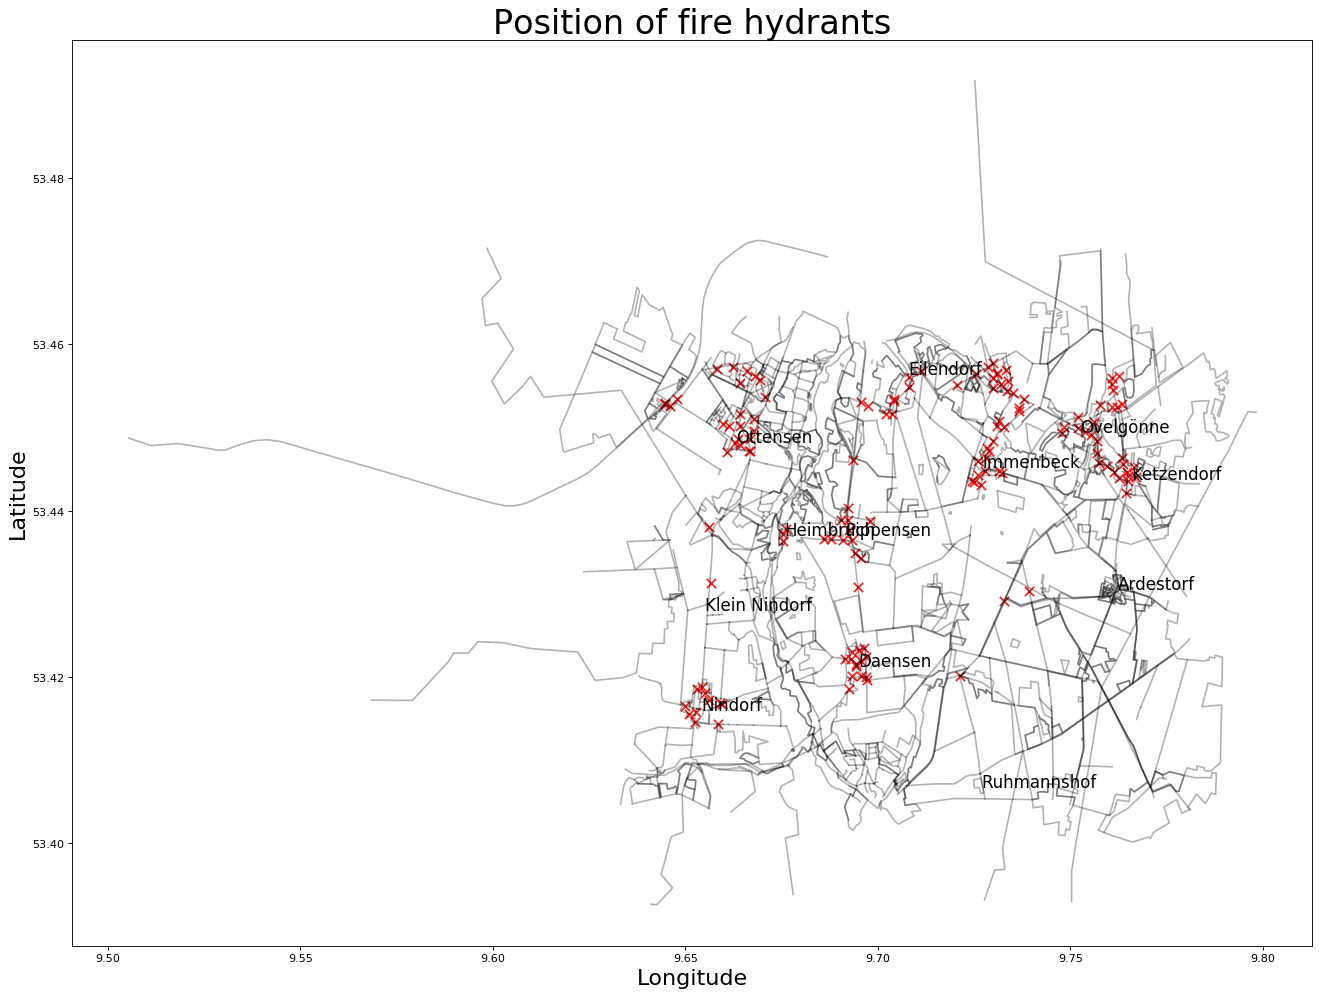

In [208]:
lat = []
lon = []
for i in res:
    lat.append(i[0])
    lon.append(i[1])



plt.figure(num=None, figsize=(20, 15), dpi=80, facecolor='w', edgecolor='k')  
plotWays()
plt.title('Position of fire hydrants', fontdict={'fontsize': 30})
plt.xlabel('Longitude', fontdict={'fontsize': 20})
plt.ylabel('Latitude', fontdict={'fontsize': 20})
plt.scatter(lon, lat, marker='x', s=70, c='r', alpha=0.9)
plt.show()

## Check of the name of the objects

In [19]:
c.execute('SELECT DISTINCT value FROM ways_tags WHERE type == \'name\'')
c.fetchall()

[('Golf Club Buxtehude',),
 ('Daensener Weg',),
 ('Daenser Weg',),
 ('Zum Baaksberg',),
 ('Zum Lehmfeld',),
 ('Koppelstieg',),
 ('Moisburger Landstraße',)]

# Close the database

In [20]:
conn.close()